In [1]:
import numpy as np
import pylab as plt
import swyft
import torch
from scipy import stats
%load_ext autoreload
%autoreload 2

np.random.seed(25)
torch.manual_seed(25)

In [126]:
DEVICE = 'cuda:0'
NSAMPLES = 100000
MAX_EPOCHS = 100

In [127]:
def model(z):
    grid = np.linspace(-1, 1, 32, 32)
    X, Y = np.meshgrid(grid, grid)
    mu = np.zeros_like(X)
    for i in range(len(z)-2):
        mu += z[i] * np.cos(X*z[i+1]*i + z[i+2]*2) * np.cos(Y*z[i+2]*i + z[i+1]*2)        
    return mu

def noisemodel(x, z = None, sigma = 0.5):
    n = np.random.randn(*x.shape)*sigma
    return x + n

In [128]:
# Convolutional network as HEAD of inference network

class Head(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 10, 3)
        self.conv2 = torch.nn.Conv2d(10, 20, 3)
        self.conv3 = torch.nn.Conv2d(20, 40, 3)
        self.pool = torch.nn.MaxPool2d(2)
        
    def forward(self, x):
        nbatch = len(x)
        
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = x.view(nbatch, -1)

        return x

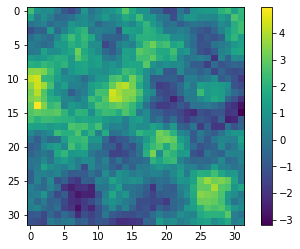

In [116]:
z0 = np.random.rand(20)
zdim = len(z0)
x0 = noisemodel(model(z0))
comb1d = [[i] for i in range(zdim)]

plt.imshow(x0)
plt.colorbar()

In [129]:
ds = swyft.DataStore().init(zdim = zdim, xdim = (32, 32))

Creating empty datastore: None
...don't forget to run `init` to set up storage parameters.
Datastore initialized.


In [130]:
re_prev = None
for r in range(1):
    td = swyft.TrainData(x0 = x0, zdim = zdim, noisehook = noisemodel, datastore = ds, nsamples = NSAMPLES, threshold = 1e-4, parent = re_prev)
    ds.simulate(model)
    re = swyft.RatioEstimation(zdim, td, device = DEVICE, combinations = comb1d, head = Head)
    re.train(max_epochs = MAX_EPOCHS, nbatch = 32, lr_schedule = [2e-3, 1e-3, 5e-4, 2.5e-4, 1.25e-4])
    re_prev = re

Constrained posterior area: 1.0
Adding 100178 new samples. Run simulator!


Simulate: 100%|██████████| 100178/100178 [05:40<00:00, 293.98it/s]


Number of output features: 160
Start training
LR iteration 0
Total epochs: 8
Validation losses: [49.23445773124695, 47.41281604766846, 46.65927600860596, 46.088308334350586, 45.66179800033569, 45.624213218688965, 45.12083172798157, 45.13154363632202]
LR iteration 1
Total epochs: 2
Validation losses: [44.309706687927246, 44.32365560531616]
LR iteration 2
Total epochs: 3
Validation losses: [44.00931739807129, 43.945884704589844, 44.00524139404297]
LR iteration 3
Total epochs: 2
Validation losses: [43.630850076675415, 43.74339818954468]
LR iteration 4
Total epochs: 3
Validation losses: [43.5876145362854, 43.50954246520996, 43.63162851333618]


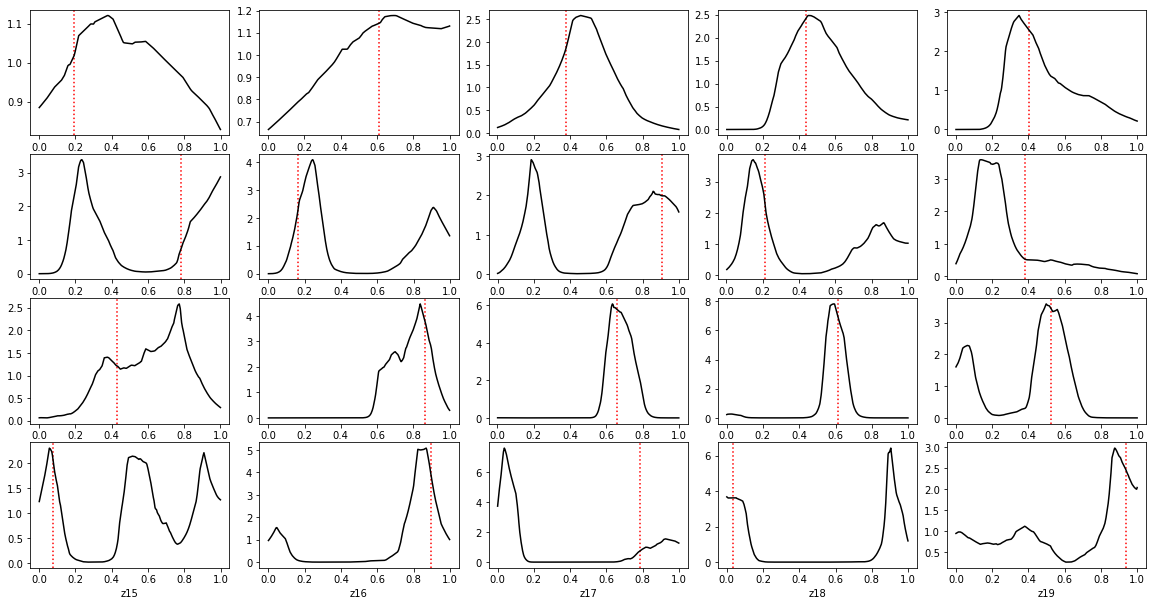

In [131]:
swyft.plot1d(re, x0 = x0, z0 = z0, cmap = 'Greys', dims = (20, 10), ncol = 5)